## Предсказание совершения покупки пользователем во время его сессии на сайте некоторого интернет-магазина

Данный проект представляет собой сквозную реализацию типичного рабочего процесса специалиста по данным, охватывающую все ключевые этапы. В ходе работы будет:

1. Проведение анализа данных
2. Построение и оптимизация модели машинного обучения
3. Оценка важности различных факторов, влияющих на решение о покупке.

#### Описание датасета

**Основные метрики поведения:**

1. Administrative - Количество посещений страниц управления аккаунтом (настройки, профиль)

2. Administrative_Duration - Общее время на административных страницах (в секундах)

3. Informational - Число просмотров информационных разделов (описания, FAQ)

4. Informational_Duration - Время, проведенное в информационных разделах

5. ProductRelated - Количество посещений товарных страниц (каталог, карточки товаров)

6. ProductRelated_Duration - Время просмотра товаров

**Метрики взаимодействия:**

7. BounceRates - Процент "отскоков" (сеансы с просмотром только одной страницы)

8. ExitRates - Процент завершений сеанса с конкретной страницы

9. PageValues - Оценка ценности страницы для конверсии (чем выше, тем важнее)

10. SpecialDay - Учет специальных дат (1.0 = день события, 0.5 = неделя до события)

**Технические параметры:**

11. Month - Месяц посещения (текстовые значения: "Feb", "Mar" и т.д.)

12. OperatingSystems - Тип ОС (цифровые коды: 1=Windows, 2=Mac и др.)

13. Browser - Используемый браузер (цифровые идентификаторы)

14. Region - Географический регион (1-9, где 1=Северная Америка)

15. TrafficType - Источник трафика (1=прямой заход, 2=поисковик и т.д.)

**Поведенческие характеристики:**

16. VisitorType - Категория посетителя ("New_Visitor", "Returning_Visitor", "Other")

17. Weekend - Флаг визита в выходные дни

**Целевая переменная:**

18. Revenue - Флаг совершения покупки (True/False)

#### Часть 1. Подготовка данных

Проведем импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score , recall_score , f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score, learning_curve

Прочитаем файл и посмотрим хорошо ли всё загрузилось

In [2]:
df_data = pd.read_csv('online_shoppers_intention.csv')
df_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Файл успешно открывается

Выведем сводную информацию о структуре данных

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Видим, что у нас 17 признаков и 1 целевая переменная (Revenue). Всего 2 категориальные переменные VisitorType и Month, остальные числовые.

Теперь проверим данные на пропуски и визуализируем их с помощью тепловой карты

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


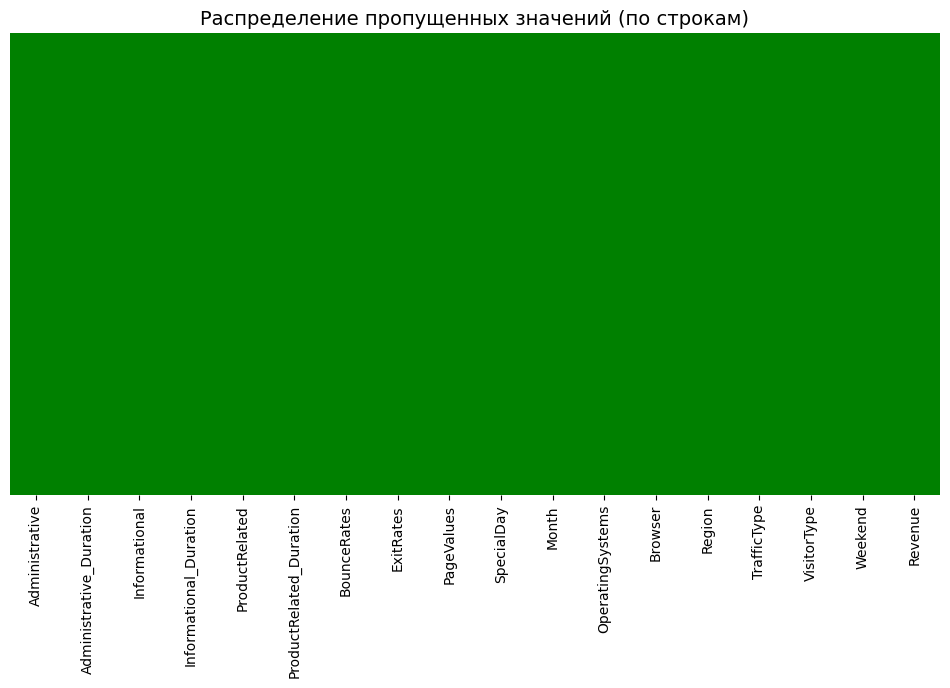

In [4]:
print(df_data.isna().sum())

plt.figure(figsize=(12, 6))
sns.heatmap(
    df_data.isnull(),  
    cmap=['green', 'red'],  # зеленый=нет пропусков, красный=есть пропуски
    cbar=False,
    yticklabels=False
)
plt.title('Распределение пропущенных значений (по строкам)', fontsize=14)
plt.show()

Отлично, пропусков в данных нет

Обработаем категориальные признаки, а именно VisitorType и Month. Посмотрим количество уникальных значений в каждом

In [5]:
for col in ['VisitorType', 'Month']:
    unique_values = df_data[col].unique()
    print(f"{col}:")
    print(unique_values)
    print(f"Количество уникальных значений: {df_data[col].nunique()}\n")

VisitorType:
['Returning_Visitor' 'New_Visitor' 'Other']
Количество уникальных значений: 3

Month:
['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
Количество уникальных значений: 10



Видим, что данные имеют определенное количество уникальных значений, поэтому закодируем их one-hot encoding, добавим параметр drop_first=True, чтобы удалить первый уровень каждого категориального признака и избежать фальшивой мультиколлинеарности

In [6]:
df_data_1 = pd.get_dummies(df_data, columns=['VisitorType', 'Month'], drop_first=True)
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  int64  
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  int64  
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  int64  
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  OperatingSystems               12330 non-null  int64  
 11  Browser                        12330 non-null  int64  
 12  Region                         12330 non-null 

Теперь итоговое количество столбцов стало 27.

#### Часть 2. Разделение данных и анализ баланса классов

Разделим данные на признаки (Х) и целевую переменную (y)

In [7]:
X = df_data_1.drop(columns=['Revenue'])
y = df_data_1['Revenue']

Построим график распределения классов (`Revenue`)

([<matplotlib.patches.Wedge at 0x2028fba7b60>,
 [Text(-0.9725550193048339, 0.5139423454289151, 'False'),
  Text(0.9725551867684546, -0.5139420285302385, 'True')],
 [Text(-0.5304845559844548, 0.28033218841577184, '84.53%'),
  Text(0.530484647328248, -0.28033201556194826, '15.47%')])

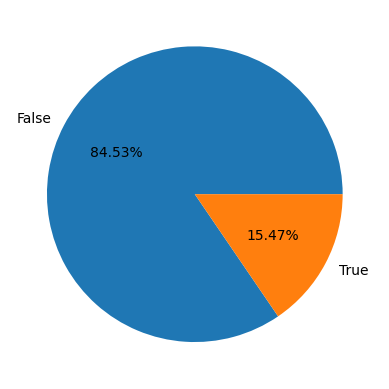

In [8]:
y_plot=pd.DataFrame(y)
plt.pie(x=y_plot['Revenue'].value_counts(), labels=["False", "True"],autopct='%.2f%%')

Видим, что наблюдается сильный дисбаланс классов. Нужно будет это учесть при делении на выборки.

Разделим данные на обучающую и тестовую выборки, зафиксировав случайность. (`random_state=42`), чтобы сохранить пропорции классов, используем аргумент `stratify=y`.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # гарантируем одинаковые доли классов в train и test
)

# Смотрим сколько значений в каждой выборке
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Проверим процентное соотношение целевой переменной в выборках
print(f"Доля оттока в train: {y_train.mean():.2f}, в test: {y_test.mean():.2f}")

Train: (9864, 26), Test: (2466, 26)
Доля оттока в train: 0.15, в test: 0.15


Чтобы в дальнейшем строить модели и исключить влияние масштаба на получаемый результат, масштабируем данные.

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_final = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Проверим масштабировались ли данные, найдя среднее по одному из признаков.

In [11]:
среднее = X_train_final['Administrative'].mean()
print(f"Среднее значение по первому признаку (округленное): {round(среднее)}")

Среднее значение по первому признаку (округленное): 0


Среднее является 0, следовательно данные масштабировались правильно

#### Часть 3. Обучение базовой модели и оценка

Обучим модель RandomForest и сделаем предсказание на тестовой выборке

In [25]:
model = RandomForestClassifier(
    class_weight='balanced',  # Для балансировки классов (т.к. у нас несбалансированные данные)
    n_estimators=200,         # Количество деревьев в лесу
    max_depth=12,             # Максимальная глубина каждого дерева
    min_samples_leaf=5,       # Минимальное количество образцов, необходимое для того, чтобы лист был листом
    random_state=42           # Для воспроизводимости результатов
)

# Обучаем модель на обучающей выборке
model.fit(X_train_final, y_train)

# Делаем предсказания классов на тестовой выборке
y_pred = model.predict(X_test_final)

# Отчет по классификации (Precision, Recall, F1-score)
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))


Отчет по классификации:
              precision    recall  f1-score   support

       False       0.95      0.90      0.92      2084
        True       0.57      0.75      0.65       382

    accuracy                           0.87      2466
   macro avg       0.76      0.82      0.79      2466
weighted avg       0.89      0.87      0.88      2466



Хоть мы и учли дисбаланс классов, но всё же результаты показывают, что модель умеет хорошо предсказывать только тех, кто не совершает покупки с достоверностью 90 % (Recall), при этом общая точность модели 87 % (Accuracy). Попробуем дальше доработать модель, чтобы повысить точность предсказаний, тех кто делает покупки.

#### Часть 4. Создание новых признаков

Воспользуемся методом кластеризации, чтобы выявить новые признаки = категории покупателей.

С помощью метода локтя найдем оптимальное количество кластеров для алгоритма KMeans, перебирая числа от 1 до 29 и вычисляя инерцию (сумму квадратов расстояний до центроидов) для каждого значения. Результат отобразим на графике, где сможем увидеть "локоть" — точку, после которой улучшение инерции замедляется, и выберем оптимальное количество кластеров.

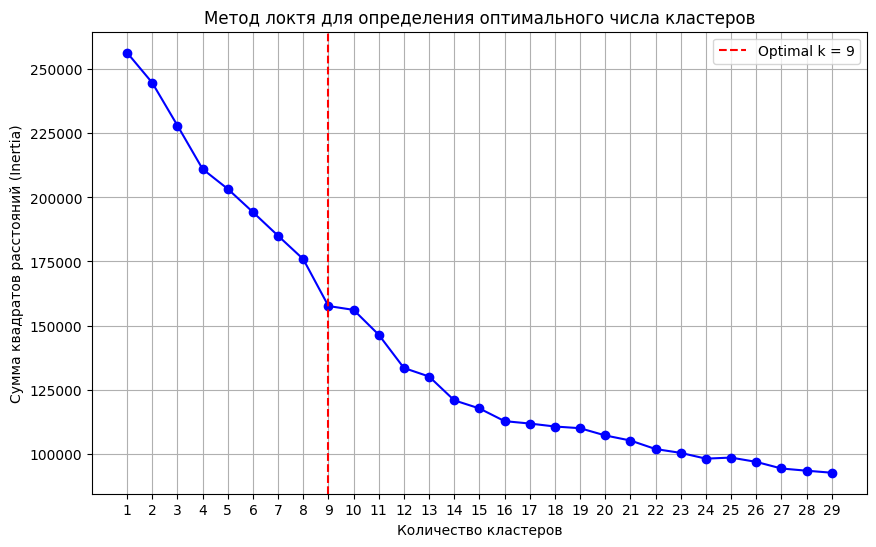

In [13]:
inertia = []
k_range = range(1, 30)  # Проверяем от 1 до 30 кластеров

for k in k_range:
    kmeans = KMeans(n_clusters=k,  n_init='auto', random_state=42)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)  # Сумма квадратов расстояний до центроидов
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний (Inertia)')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.xticks(k_range)
# поиск "локтя" (оптимального k)
# для этого найдем точку, где уменьшение inertia начинает замедляться
# используем вторую производную для нахождения точки перегиба
diff = np.diff(inertia)  # первая производная
diff2 = np.diff(diff)    # вторая производная
optimal_k = np.argmax(diff2) + 2  # +2, так как diff2 имеет длину на 2 меньше

# добавляем вертикальную линию для оптимального k
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.grid()
plt.show()

Таким образом, оптимальное количество кластеров получилось равным 9.

Теперь применим PCA, чтобы выяснить, сколько главных компонент нужно оставить, чтобы сохранить уровень дисперсии 55%, и снизить размерность признаков с минимальной потерей информации.

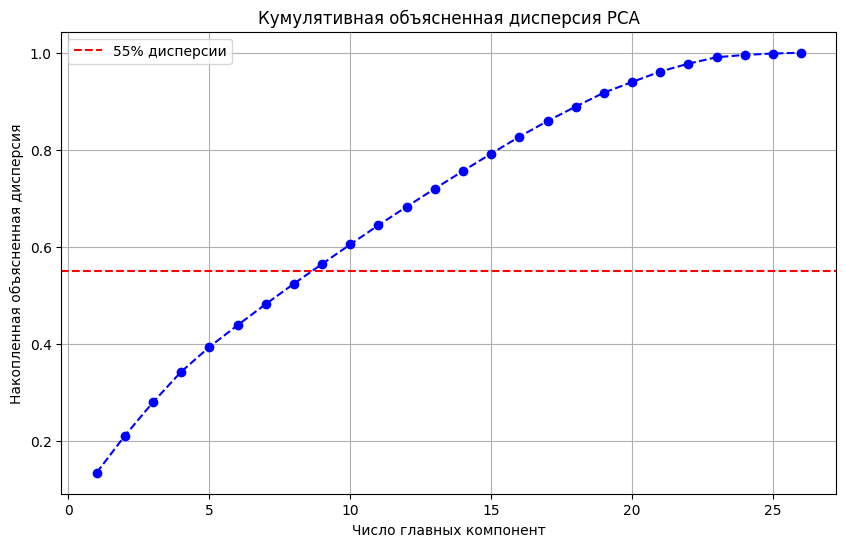

Компонент для 55% дисперсии: 9

Фактически сохраненная дисперсия: 56.46%


In [14]:
# Применяем PCA с максимальным числом компонент (равным числу признаков)
pca = PCA(n_components=X_train_scaled.shape[1])  # автоматически определяем максимальное число компонент
transformed = pca.fit_transform(X_train_scaled)

# Вычисляем накопленную сумму дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Строим график накопленной объясненной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance,
         marker='o', linestyle='--', color='b')
plt.xlabel("Число главных компонент")
plt.ylabel("Накопленная объясненная дисперсия")
plt.title("Кумулятивная объясненная дисперсия PCA")
plt.grid(True)
plt.axhline(y=0.55, color='r', linestyle='--', label="55% дисперсии")
plt.legend()
plt.show()

# Находим оптимальное число компонент для 55% дисперсии
optimal_55 = np.argmax(explained_variance >= 0.55) + 1
print(f"Компонент для 55% дисперсии: {optimal_55}")

# Создаем PCA с оптимальным числом компонент
pca_opt = PCA(n_components=optimal_55)
X_train_pca = pca_opt.fit_transform(X_train_scaled)
X_test_pca = pca_opt.transform(X_test_scaled)  # применяем PCA для тестовых данных

# Фактически сохраненная дисперсия
print(f"\nФактически сохраненная дисперсия: {np.sum(pca_opt.explained_variance_ratio_):.2%}")

Минимальное число компонент, достигающее уровня дисперсии 55% равно 9. Вместо всех исходных признаков теперь выбрали 9 новых признаков (главных компонент), которые сохраняют 56,46% информации от исходного набора. Это может улучшить качество моделей и уменьшить переобучение.

Далее добавим к обучающим и тестовым данным новые признаки: кластерные метки, полученные с помощью KMeans, и главные компоненты, рассчитанные с помощью PCA.  
Всё обучение (fit) выполняется только на тренировочной выборке, а затем те же преобразования применяются к тестовой. Это помогает обогатить данные и потенциально улучшить качество модели.

In [15]:
# Обучение KMeans на только обучающих данных
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

# создание нового датасета
# добавляем кластеры к обучающей выборке
X_train['Cluster'] = clusters

# Прогнозируем кластеры для тестовых данных, используя обученный кластеризатор
clusters_test = kmeans.predict(X_test_scaled)  # только predict на тестовых данных
X_test['Cluster'] = clusters_test

# Создание PCA на обучающих данных
pca_opt = PCA(n_components=optimal_55)
X_train_pca = pca_opt.fit_transform(X_train_scaled)  # fit только на обучающих данных
X_test_pca = pca_opt.transform(X_test_scaled)  # применяем transform на тестовых данных

# добавляем компоненты к тренировочным данным и тестовым данным (используем обученный PCA)
for i in range(9):
    X_train[f'PCA_{i+1}'] = X_train_pca[:, i]
    X_test[f'PCA_{i+1}'] = X_test_pca[:, i]

Проверим, что добавленные новые признаки (кластеры и PCA-компоненты) корректно встроились в данные, и финальные таблицы готовы к подаче в модель.

In [16]:
# выведем размеры частей, чтобы убедиться, что они стыкуются без проблем
print("X_train_scaled:", X_train_scaled.shape)
print("Cluster column:", X_train[['Cluster']].shape)

# Собираем список имён PCA‑столбцов
pca_cols = [f'PCA_{i+1}' for i in range(9)]
print("PCA columns:", X_train[pca_cols].shape)

# Итого
print("Всего признаков:", X_train_scaled.shape[1] + 1 + len(pca_cols))

X_train_scaled: (9864, 26)
Cluster column: (9864, 1)
PCA columns: (9864, 9)
Всего признаков: 36


In [17]:
print("X_test_scaled:",  X_test_scaled.shape) 
print("Cluster column:",  X_test[['Cluster']].shape) 
print("PCA columns:",     X_test[pca_cols].shape) 
print("Всего признаков:", X_test_scaled.shape[1] + 1 + len(pca_cols))

X_test_scaled: (2466, 26)
Cluster column: (2466, 1)
PCA columns: (2466, 9)
Всего признаков: 36


Мы убедились, что как обучающая, так и тестовая выборки имеют одинаковое число итоговых признаков

Собирем финальные тренировочные и тестовые таблицы признаков для машинного обучения

In [18]:
# 1. Получаем список имён для стандартизированных признаков

scaled_cols = X_train.columns.difference(['Cluster'] + [f'PCA_{i+1}' for i in range(9)])

# 2. Формируем финальные DataFrame с сохранёнными именами
X_train_itog = pd.concat([
    pd.DataFrame(X_train_scaled, columns=scaled_cols, index=X_train.index),  # стандартизированные признаки
    X_train[['Cluster']],
    X_train[[f'PCA_{i+1}' for i in range(9)]]
], axis=1)

X_test_itog = pd.concat([
    pd.DataFrame(X_test_scaled, columns=scaled_cols, index=X_test.index),
    X_test[['Cluster']],
    X_test[[f'PCA_{i+1}' for i in range(9)]]
], axis=1)

Теперь применим PCA для визуализации (уменьшаем размерность до 2 признаков)

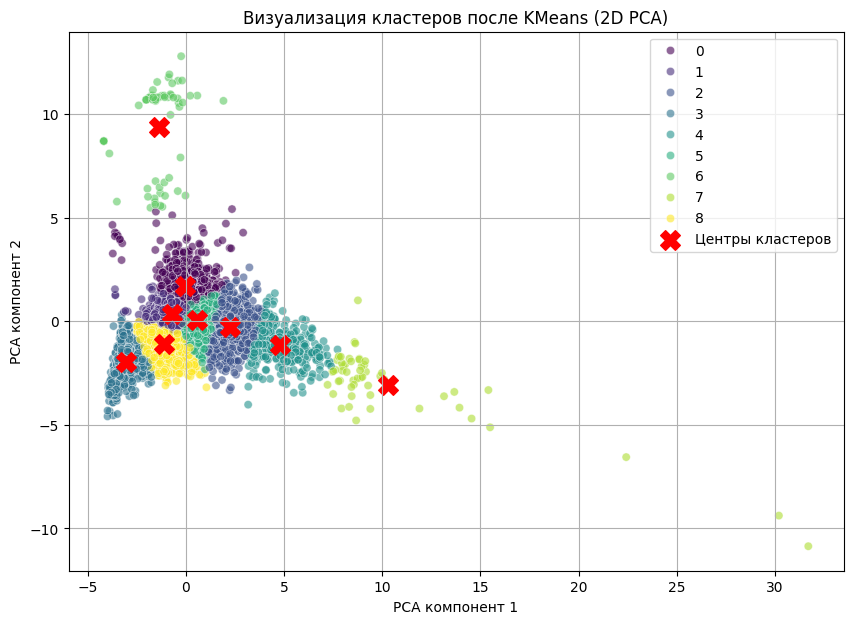

In [19]:
# PCA до 2 компонент
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

# Обучаем KMeans заново на этих 2 компонентах (только для визуализации)
kmeans_2d = KMeans(n_clusters=optimal_k, random_state=42)
clusters_2d = kmeans_2d.fit_predict(X_pca_2d)

# Получаем координаты центров кластеров
centroids_2d = kmeans_2d.cluster_centers_

# Визуализация
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
                hue=clusters_2d, palette='viridis', alpha=0.6, legend='full')

# Рисуем центроиды
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c='red', s=200, marker='X', label='Центры кластеров')

plt.title('Визуализация кластеров после KMeans (2D PCA)')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.legend()
plt.grid(True)
plt.show()

Разноцветные точки — объекты, разбитые на кластеры.

Красные кресты (X) — центры кластеров.

Цвет — номер кластера (автоматически назначается).

Подготовка данных завершена, попробуем ещё раз обучить модель

#### Часть 5. Обучение модели на расширенном датасете

После того как добавили в признаки кластеризацию и компонентный анализ (PCA), обучим улучшенную модель Random Forest на расширенных данных. Проведем её оценку с использованием отчёта classification_report.

Ещё раз проверим, что всё хорошо отображается и все признаки на месте

In [20]:
X_train_itog.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month_Dec,Month_Feb,Month_Jul,...,Cluster,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
4263,1.712088,3.624745,-0.395782,-0.244589,0.058405,0.083393,-0.353793,-0.612923,0.341014,3.663440,...,3,1.388454,-1.308983,1.439245,3.394669,-0.747806,-0.255905,-0.886271,0.788464,-0.687720
5905,-0.698294,-0.452341,-0.395782,-0.244589,-0.629459,-0.539163,0.360698,1.159262,-0.320268,-0.311499,...,8,-1.287956,0.603438,-0.260699,-0.515310,-0.646727,-1.205251,-1.947665,0.665691,0.035270
9434,-0.698294,-0.452341,-0.395782,-0.244589,-0.629459,-0.599504,-0.458865,0.136746,-0.320268,-0.311499,...,1,-1.106839,1.901977,0.828344,-0.099625,-0.810442,0.372688,2.416722,0.104354,-0.403588
3505,-0.095698,1.429605,-0.395782,-0.244589,-0.331385,0.009963,-0.202751,-0.118883,0.716100,3.663440,...,3,-0.308443,-1.529363,1.039743,3.138097,-0.112714,-0.002683,-0.195722,0.063353,-0.513428
2067,-0.698294,-0.452341,-0.395782,-0.244589,0.012548,-0.187989,-0.458865,-0.873776,2.625461,-0.311499,...,5,-0.107753,1.104761,-1.495580,0.149697,-0.658805,1.550381,-0.359722,-0.076836,-0.318670


In [26]:
model_optim = RandomForestClassifier(
    class_weight='balanced',  # Для балансировки классов (т.к. у нас несбалансированные данные)
    n_estimators=200,         # Количество деревьев в лесу
    max_depth=12,             # Максимальная глубина каждого дерева
    min_samples_leaf=5,       # Минимальное количество образцов, необходимое для того, чтобы лист был листом
    random_state=42           # Для воспроизводимости результатов
)
# Обучаем модель на обучающей расширенной выборке
model_optim.fit(X_train_itog, y_train)

# Предсказания на обучающей выборке
train_preds = model_optim.predict(X_train_itog)
print("Отчет по обучающей выборке:")
print(classification_report(y_train, train_preds))

# Предсказания на тестовой выборке
test_preds = model_optim.predict(X_test_itog)
print("Отчет по тестовой выборке:")
print(classification_report(y_test, test_preds))

Отчет по обучающей выборке:
              precision    recall  f1-score   support

       False       0.99      0.93      0.96      8338
        True       0.71      0.94      0.81      1526

    accuracy                           0.93      9864
   macro avg       0.85      0.93      0.88      9864
weighted avg       0.95      0.93      0.93      9864

Отчет по тестовой выборке:
              precision    recall  f1-score   support

       False       0.95      0.91      0.93      2084
        True       0.59      0.73      0.65       382

    accuracy                           0.88      2466
   macro avg       0.77      0.82      0.79      2466
weighted avg       0.89      0.88      0.88      2466



Видно, что модель немного переобучена на тренировочных данных, т.к. сильно разнятся значения метрик класса True в тренировочной и тестовой выборках. Значит потребуется корректировка параметров модели, чтобы исключить переобучение. 

Выполним индивидуальное предсказание для одного объекта, например с индексом 25, из тестовой выборки с помощью ранее обученной модели и проанализируем результат, чтобы проверить как работает модель точечно.

Для этого выберем один конкретный объект по индексу из тестовой выборки (X_test_itog) и извлекем истинное значение метки целевой переменной y_test для этого объекта.

Индекс объекта: 25
Истинная метка (true_label): False
Предсказанная моделью метка (pred[0]): False
Вероятности принадлежности к классам: [0.95745453 0.04254547]
Предсказание верно!


C:\Users\likha\AppData\Local\Temp\ipykernel_4024\1973897466.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Не купит', 'Купит'], y=pred_one[0], palette=['red', 'green'])


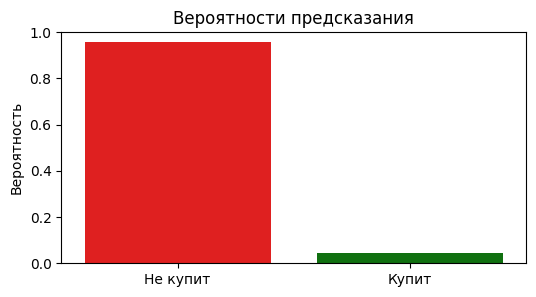

In [29]:
X_test_one = X_test_itog.iloc[[25]]
true_label = y_test.iloc[25]

# Делаем предсказание класса
pred = model_optim.predict(X_test_one)

# Делаем предсказание вероятностей принадлежности к классам
pred_one = model_optim.predict_proba(X_test_one)

# Вывод результатов
print(f"Индекс объекта: {25}")
print(f"Истинная метка (true_label): {true_label}")
print(f"Предсказанная моделью метка (pred[0]): {pred[0]}")

print(f"Вероятности принадлежности к классам: {pred_one[0]}")

# Дополнительная информация:
if pred[0] == true_label:
    print("Предсказание верно!")
else:
    print("Предсказание неверно.")

plt.figure(figsize=(6, 3))
sns.barplot(x=['Не купит', 'Купит'], y=pred_one[0], palette=['red', 'green'])
plt.title('Вероятности предсказания')
plt.ylabel('Вероятность')
plt.ylim(0, 1)
plt.show()


Отлично, предсказание оказалось верным, с большой вероятностью при таких данных клиент ничего не купит

#### Часть 6. Обучение модели с подбором гиперпараметров на расширенном датасете

Попробуем улучшить нашу модель, избежав переобучения. Для этого проведем подбор гиперпараметров для модели RandomForest с использованием GridSearchCV 

In [24]:
# настройка стратегии валидации (сохраняем дисбаланс)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
# n_splits=5` → будет выполнено 5-кратное перекрестное обучение 
# shuffle=True и random_state=42` → обеспечивает воспроизводимость разбиения и предотвращает случайные выбросы при стратификации

# создаем кастомную метрику (F1 для класса 1 - "покупка")
scorer = make_scorer(f1_score, pos_label=1)

# расширенная сетка параметров
params = {
    'n_estimators': [100, 200, 300],     # число деревьев
    'max_depth': [8, 10, 12, None],         # глубина
    'min_samples_leaf': [1, 3, 5],       # мин. листьев
    'class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}],
    'max_features': ['sqrt', 0.8]        # как выбирать фичи
}

rf = RandomForestClassifier(
    class_weight='balanced', 
    random_state=42,
)
grid = GridSearchCV(rf, params, cv=5, scoring='f1')

# инициализация модели
grid.fit(X_train_itog, y_train)

# лучшая модель
best_rf = grid.best_estimator_
print(f"Лучшие параметры: {grid.best_params_}")
print(classification_report(y_test, best_rf.predict(X_test_itog)))

Лучшие параметры: {'class_weight': {0: 1, 1: 3}, 'max_depth': 8, 'max_features': 0.8, 'min_samples_leaf': 3, 'n_estimators': 300}
              precision    recall  f1-score   support

       False       0.95      0.92      0.93      2084
        True       0.63      0.71      0.67       382

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.80      2466
weighted avg       0.90      0.89      0.89      2466



Качество предсказания на тестовой выборке улучшилось, precision 0.59 -> 0.63, f1-score 0.65 -> 0.67, accuracy 0.88 -> 0.89. Только действительных положительных значений стало меньше recall 0.73 <- 0.71.  

Снова проверим на переобучение, применив модель на тренировочной и тестовой выборках.

In [43]:
# Предсказания на обучающей выборке
train_preds = best_rf.predict(X_train_itog)
print("Отчет по обучающей выборке:")
print(classification_report(y_train, train_preds))

# Предсказания на тестовой выборке
test_preds = best_rf.predict(X_test_itog)
print("Отчет по тестовой выборке:")
print(classification_report(y_test, test_preds))

Отчет по обучающей выборке:
              precision    recall  f1-score   support

       False       0.97      0.94      0.96      8338
        True       0.73      0.85      0.78      1526

    accuracy                           0.93      9864
   macro avg       0.85      0.90      0.87      9864
weighted avg       0.93      0.93      0.93      9864

Отчет по тестовой выборке:
              precision    recall  f1-score   support

       False       0.95      0.92      0.93      2084
        True       0.63      0.71      0.67       382

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.80      2466
weighted avg       0.90      0.89      0.89      2466



Разница между метриками уменьшилась, что говорит об уменьшении воздействия переобучения с помощью подбора гиперпараметров.

Теперь посмотрим какие признаки были важны во всех трех моделях: без добавления признаков (базовая модель), с добавлением признаков без подбора гиперпараметров (улучшенная модель), с добавлением признаков с подбором гиперпараметров (оптимизированная модель).

Базовая модель


C:\Users\likha\AppData\Local\Temp\ipykernel_4024\1431061213.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


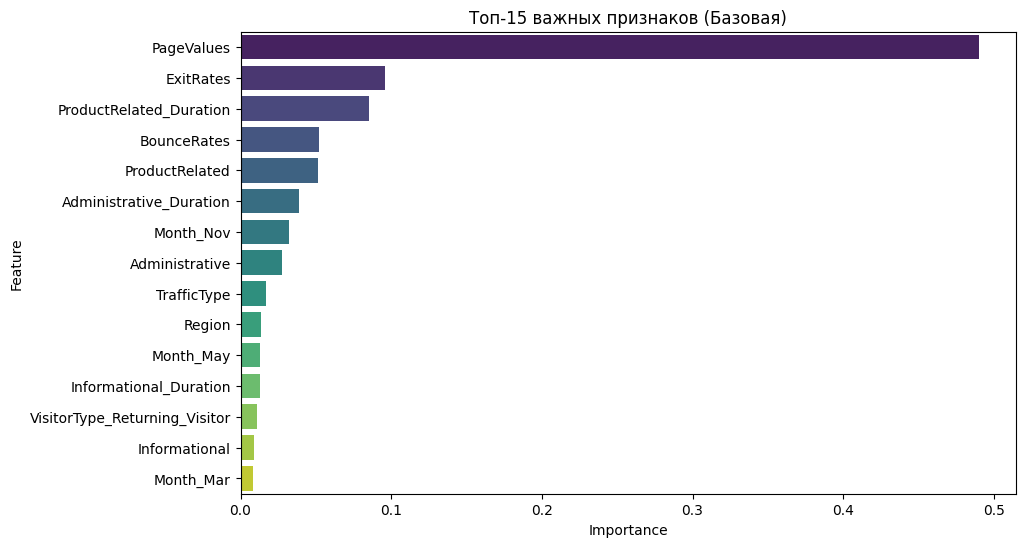

Улучшенная модель


C:\Users\likha\AppData\Local\Temp\ipykernel_4024\1431061213.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


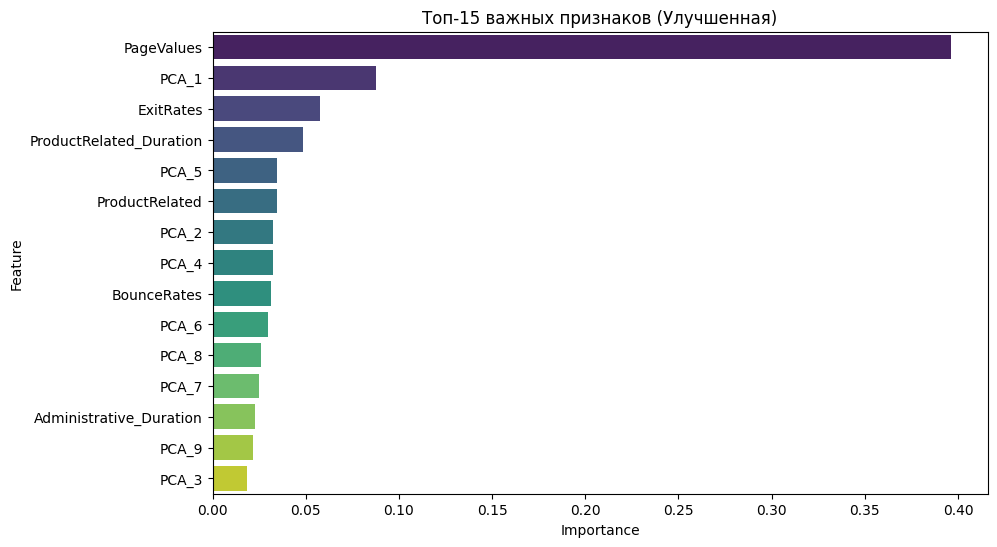

Оптимизированная модель


C:\Users\likha\AppData\Local\Temp\ipykernel_4024\1431061213.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


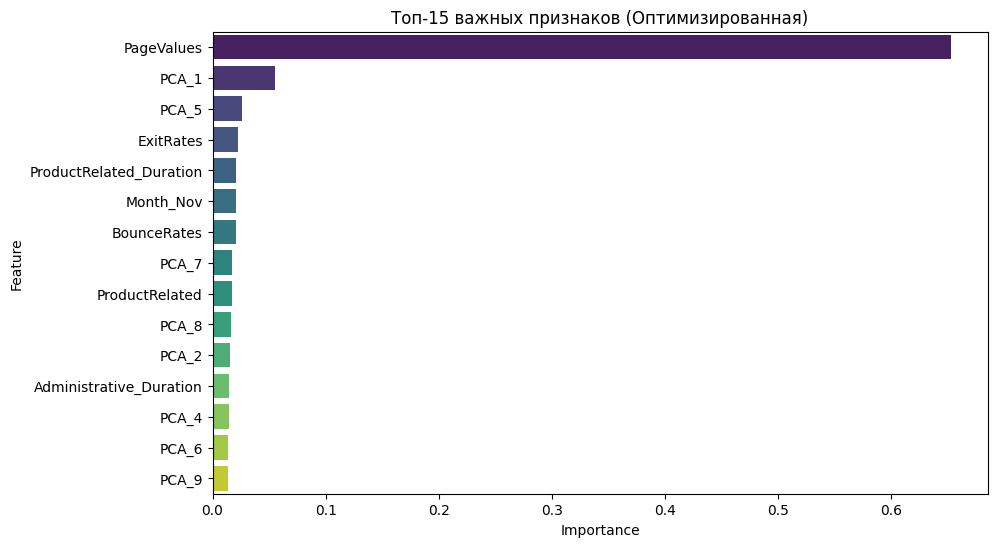


Сравнение новых признаков:


,Признак,Ранг в улучшенной,Важность в улучшенной,Ранг в оптимизированной,Важность в оптимизированной
1,PCA_1,27,0.087849,27,0.055420
5,PCA_5,31,0.034647,31,0.025843
2,PCA_2,28,0.032593,28,0.015743
4,PCA_4,30,0.032440,30,0.014297
6,PCA_6,32,0.029933,32,0.013733
8,PCA_8,34,0.026090,34,0.016320
7,PCA_7,33,0.025135,33,0.017614
3,PCA_3,29,0.018651,29,0.012543
0,Cluster,26,0.016781,26,0.011320


In [28]:
def get_feature_importance(model, feature_names):
    """Возвращает важность признаков в виде DataFrame"""
    return pd.DataFrame({
        'Feature': feature_names[:len(model.feature_importances_)],  # Защита от несоответствия размеров
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

# получаем важность признаков для всех моделей
base_features = [f for f in X_train.columns if not f.startswith(('Cluster', 'PCA_'))]
base_importance = get_feature_importance(model, base_features)

# для улучшенной модели проверяем наличие новых признаков
enhanced_features = X_train.columns.tolist()
enhanced_importance = get_feature_importance(model_optim, enhanced_features)

optimized_importance = get_feature_importance(best_rf, enhanced_features)

# визуализация для каждой модели
def plot_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Топ-15 важных признаков ({title})')
    plt.show()

print("="*50 + "\nБазовая модель\n" + "="*50)
plot_importance(base_importance, "Базовая")

print("="*50 + "\nУлучшенная модель\n" + "="*50)
plot_importance(enhanced_importance, "Улучшенная")

print("="*50 + "\nОптимизированная модель\n" + "="*50)
plot_importance(optimized_importance, "Оптимизированная")

# сравнение новых признаков (только если они существуют)
new_features = [f for f in ['Cluster'] + [f'PCA_{i+1}' for i in range(8)]
               if f in enhanced_importance['Feature'].values]

if new_features:
    new_features_report = pd.DataFrame({
        'Признак': new_features,
        'Ранг в улучшенной': [enhanced_importance[enhanced_importance['Feature'] == f].index[0]
                            for f in new_features],
        'Важность в улучшенной': [enhanced_importance[enhanced_importance['Feature'] == f]['Importance'].values[0]
                                for f in new_features],
        'Ранг в оптимизированной': [optimized_importance[optimized_importance['Feature'] == f].index[0]
                            for f in new_features],
        'Важность в оптимизированной': [optimized_importance[optimized_importance['Feature'] == f]['Importance'].values[0]
                                for f in new_features]
    })

    print("\nСравнение новых признаков:")
    display(new_features_report.sort_values('Важность в улучшенной', ascending=False))
else:
    print("\nНовые признаки не найдены в модели")

Во всех трех моделях самым важным признаком является PageValues - Оценка ценности страницы для конверсии. Далее в моделях с расширенными признаками идет PCA 1 и после ExitRates - Процент завершений сеанса с конкретной страницы, который также в топе всех моделей. 

Посмотрим, какая категория людей входит в PCA_1, для этого рассмотрим как каждый признак влияет на эту категорию людей

In [41]:
affect = pca_opt.components_
affect_df = pd.DataFrame(affect, columns=X_train_final.columns, index=[f'PCA_{i+1}' for i in range(optimal_k)])
affect_df.head(1)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,VisitorType_Returning_Visitor,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
PCA_1,0.37288,0.316349,0.338702,0.290779,0.4048,0.404182,-0.274579,-0.320434,0.095629,-0.095427,...,0.002422,-0.005047,-0.058842,0.005983,-0.009319,-0.039187,-0.098593,0.115621,0.043022,0.031998


Можем предположить, что люди, которые покупают, они больше и дольше посещают страницы сайта, связанные с профилем и продуктами (Administrative, Administrative_Duration, ProductRelated и ProductRelated_Duration), подробно изучают информационные страницы (Informational и Informational_Duration) и т.д., т.е. те кого заинтересовали товары, персональные предложения магазина и кто в целом внимательно изучает сайт с целью знакомства с магазином.

#### Выводы

Таким образом, модель, которая показала наилучшие метрики, это модель с добавленными признаками, кластерами, у которой минимизировали вероятность переобучения.

**Итоговые метрики оптимизированной модели**
1. Precision 0.63 
2. F1-score 0.67 
3. Accuracy 0.89 
4. Recall 0.71

**Важные признаки**
1. PageValues
2. PCA_1
3. PCA_5
4. ExitRates
5. ProductRelated_Duration